# Algorítmo de limpieza de potencia aparente de Circuitos

El presente algorítmo permitirá obtener valores de potencia aparente validada para almacenarla en el DWH, la estampa de tiempo de la validación es de 1 minuto.

### Pasos a seguir durante el proceso:

    - Limpieza de outliers con el Método: IQR
    - Aplicación del algoritmo de validación de máximos y mínimos
    - Almacenamiento de los datos validados en el DWH

### Limpieza de outliers con el Método: IQR

Utilizaremos la biblioreca **scipy** la cual tiene listo el algoritmo IQR para ser implementado.

In [1]:
### Importación de clases y paquetes

from GetCircuitos import GetCircuitos
from pyspark.sql.functions import to_timestamp, col, regexp_replace
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

#### Obtención de los datos de Circuitos desde el HDFS ( POTENCIA DESTINO)

In [2]:
# Datos de entrada

fecha_inicio = datetime.datetime.strptime('2019-10-10 00:00', '%Y-%m-%d %H:%M')
fecha_fin = datetime.datetime.strptime('2019-10-10 23:59', '%Y-%m-%d %H:%M')
circuito = 'GUO138VIC1'
dimension = 'Potencia Aparente'

# Datos De circuitos (DataFrame Pyspark)

getCircuitos = GetCircuitos(TableName = '', FileName='circuitos_destino_*')
circuitosDestino = getCircuitos.GetDataDestino(fecha_inicio,fecha_fin,circuito)
print(circuitosDestino.columns)
circuitosDestino.select('circuito','TagPotenciaDestino').distinct().show(truncate=False)
tag = circuitosDestino.select('TagPotenciaDestino').distinct().first()[0]

# Datos a pandas dataframe

datosDestino = circuitosDestino.toPandas().set_index('Id')

['Id', 'circuito', 'Potencia', 'Calidad', 'TagCalidadDestino', 'TagPotenciaDestino', 'Fecha', 'LimMaxOperacion', 'LimOperacionContinuo', 'LimTermico', 'NumCircuitos']
+----------+-------------------------------+
|circuito  |TagPotenciaDestino             |
+----------+-------------------------------+
|GUO138VIC1|VICENTIN138GUALO_S.LINEA_CAL.AV|
+----------+-------------------------------+



#### Definición del Algoritmo IQR, salida de datos outliers y datos limpios

In [3]:
# Método IQR

def limpiar_outliers(datos):
    datos_totales = datos.copy()
    Q1 = np.percentile(datos,25,interpolation='midpoint')
    print('Q1: '+str(Q1))
    Q3 = np.percentile(datos,75,interpolation='midpoint')
    print('Q3: '+str(Q3))
    IQR = stats.iqr(datos,interpolation='midpoint')
    print('IQR: '+str(IQR))
    limite_inferior = Q1 - (1.5*IQR)
    limite_superior = Q3 + (1.5*IQR)
    print('limite inferior: '+str(limite_inferior))
    print('limite superior: '+str(limite_superior))
    outliers = datos[(datos<limite_inferior) | (datos>limite_superior)]
    datos_totales.drop(outliers.index, inplace=True)
    return outliers,datos_totales

#### Aplicación del Algoritmo IQR

In [4]:
# Limpieza de datos

datos = datosDestino['Potencia'].copy()
outliers, datos_limpios = limpiar_outliers(datos)

Q1: 6.42224073410034
Q3: 11.9435882568359
IQR: 5.52134752273556
limite inferior: -1.8597805500030002
limite superior: 20.22560954093924


#### Descripción de los datos obtenidos

In [5]:
# Descripcón de los datos de salida

print(datos.describe())
print('================================= Datos')
print(outliers.describe())
print('================================= Ouliers')
print(datos_limpios.describe())
print('================================= Datos Limpios')

count    8049.000000
mean        9.296076
std         3.149702
min         2.058689
25%         6.422241
50%         9.587813
75%        11.943588
max        15.242789
Name: Potencia, dtype: float64
================================= Datos
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Potencia, dtype: float64
================================= Ouliers
count    8049.000000
mean        9.296076
std         3.149702
min         2.058689
25%         6.422241
50%         9.587813
75%        11.943588
max        15.242789
Name: Potencia, dtype: float64
================================= Datos Limpios


#### Gráfico para Visualizar los resultados

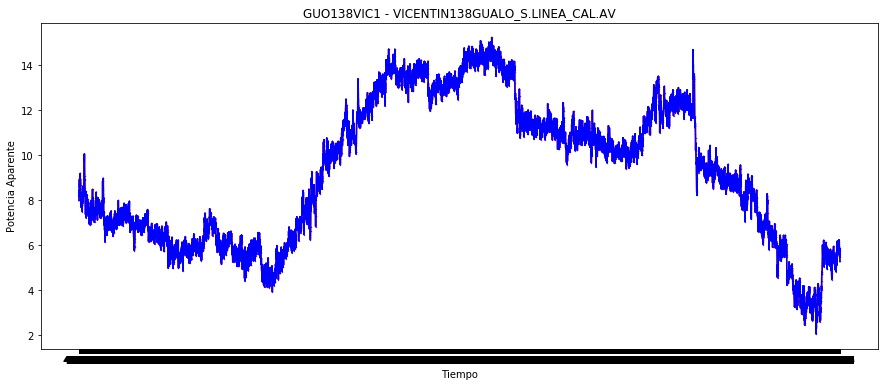

In [6]:
# Graficando los datos de salida

plt.plot(datos,color="red",markersize=0.5,marker='.')
plt.plot(datos_limpios,color="blue",markersize=0.5,marker='.')
plt.title(circuito+' - '+tag)
plt.xlabel('Tiempo')
plt.ylabel(dimension)
plt.show()

#### Gráfico BOXPLOT para visualizar los outliers

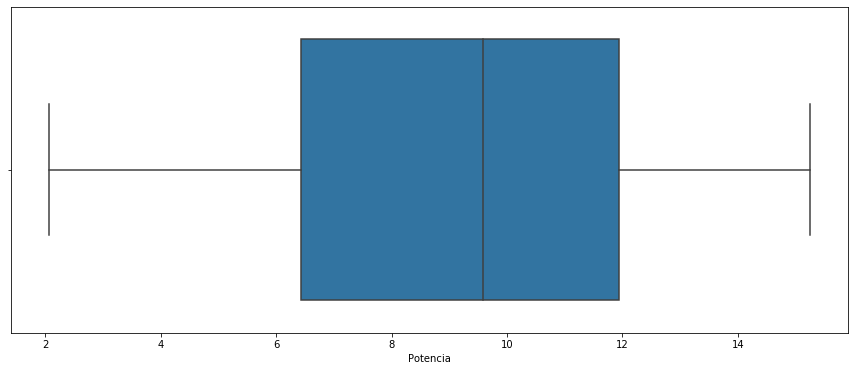

In [7]:
# Diagrama de cajas

sns.boxplot(datos)